In [1]:
import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format



In [2]:
df = wr.get_clean_data(start2018=True)
sdf = s.get_summary_df(df)
sdf = wr.add_date_features(sdf)

In [3]:
train, test = wr.split_data(sdf)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

In [5]:
pd.concat([train.tail(1), validate.head(1)])

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name
order_date,,,,,,,,,,,,,,
2021-12-31,Houston TranStar,Local Government,Houston,"Presidio Networked Solutions Group, LLC",2022-01-04,712.76,2021,4,12,52,4,365,December,Friday
2022-01-01,Teacher Retirement System of Texas,State Agency,Austin,"Presidio Networked Solutions Group, LLC",2022-04-28,"62,756.88",2022,1,1,52,5,1,January,Saturday


In [4]:
pd.concat([validate.tail(1), test.head(1)])

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name
order_date,,,,,,,,,,,,,,
2022-06-30,Travis County,Local Government,Austin,"Netsync Network Solutions, Inc.",2022-07-31,"33,530.00",2022,2,6,26,3,181,June,Thursday
2022-07-01,Austin Community College,Higher Ed,Austin,"Presidio Networked Solutions Group, LLC",2022-07-05,"13,918.00",2022,3,7,26,4,182,July,Friday


## Create time series with daily resampling

In [13]:
X_train_ts = train.purchase_amount.copy().resample('D').sum()
X_validate_ts = validate.purchase_amount.copy().resample('D').sum()
X_test_ts = test.purchase_amount.copy().resample('D').sum()

In [14]:
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()

In [8]:
X_validate.shape[0] == len(X_validate_ts)

True

In [15]:
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

In [16]:
# back to mean!!! median's RMSE is very high
baseline = X_train_ts.mean()

In [17]:
baseline

654835.7355890411

In [18]:
def evaluate(target_name: str, model_name: str):
    RMSE_train = round(np.sqrt(mean_squared_error(X_train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(X_validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
    # plot
    plt.figure(figsize = (12,4))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

In [19]:
def evaluate_rmse(target_name: str, model_name: str):
    RMSE_train = round(np.sqrt(mean_squared_error(X_train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(X_validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
def plot_model(target_name: str, model_name: str):
    plt.figure(figsize = (12,4))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

In [20]:
target = 'purchase_amount'

In [21]:
predictions_train = pd.DataFrame(index=X_train.index)
predictions_validate = pd.DataFrame(index=X_validate.index)
predictions_train['baseline'] = baseline
predictions_validate['baseline'] = baseline

purchase_amount -- RMSE train: 877795
purchase_amount -- RMSE validate: 810253


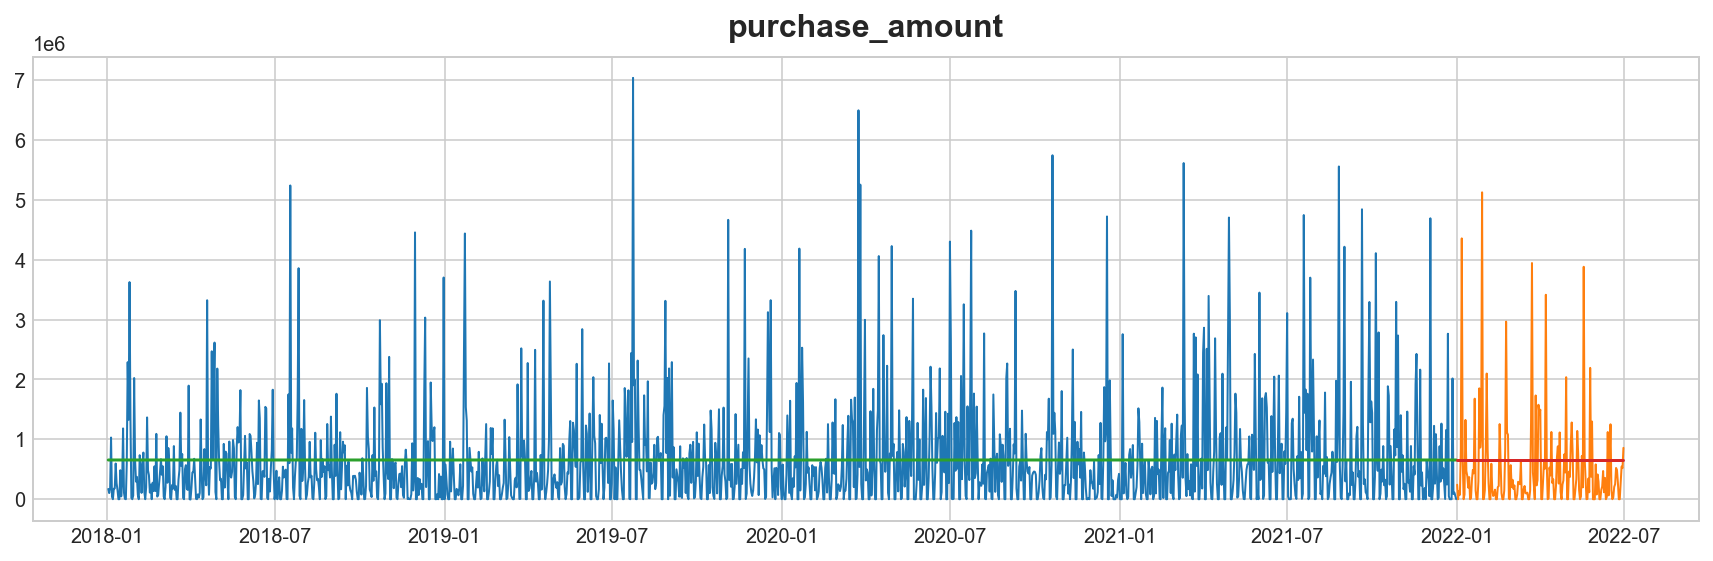

In [78]:
evaluate(target_name='purchase_amount', model_name='baseline')

In [38]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253


### Moving Average

In [38]:
def model_moving_average(span=3):
    '''
    Create moving averages statistical models.
    Saves results to predictions_train and predictions_validate
    Evaluate models and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # assign the period for the moving average
    span = span
    # identify the model
    model_name = 'Moving Average' + ' ' + str(span)
    # create a baseline value of moving average
    ma_baseline = round(X_train.purchase_amount.rolling(span).mean()[-1], 2)
    
    # rolling amounts to fill train and validate sets
    rolling_amount_train = round(X_train.purchase_amount.rolling(span).mean(), 2).fillna(ma_baseline)
    rolling_amount_validate = round(X_validate.purchase_amount.rolling(span).mean(), 2)
    # slicing index to replace the indexes in the beginning of validation set with the last values of train set
    temp_index = span - 1
    # put rolling moving average values to the predictions train
    predictions_train[model_name] = rolling_amount_train
    # replace validate nulls with last values of train set
    rolling_amount_validate[:temp_index] = predictions_train[model_name][-temp_index:].values
    # put predictions into predictions validate
    predictions_validate[model_name] = rolling_amount_validate
    # evaluate and save results into scores data frame
    evaluate_rmse(target, model_name)

In [41]:
scores

,model_name,train_score,validate_score
0,Moving Average 2,585705,523689
1,Moving Average 3,707206,646148
2,Moving Average 4,761101,712618
3,Moving Average 5,795766,740410
4,Moving Average 6,814718,746364
...,...,...,...
265,Moving Average 86,870632,814720
266,Moving Average 87,871203,816954
267,Moving Average 88,872546,819101
268,Moving Average 89,872514,816928


In [40]:
for i in range(2, 91):
    model_moving_average(i)

In [42]:
def model_exponential_moving_average(span=3):
    '''
    Create exponential moving averages statistical models.
    Saves results to predictions_train and predictions_validate
    Evaluate models and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # identify the model
    model_name = 'Exp Moving Average' + ' ' + str(span)
    predictions_train[model_name] = X_train.ewm(span=span).mean()
    predictions_validate[model_name] = X_validate.ewm(span=span).mean()
    evaluate_rmse(target, model_name)

In [43]:
for i in range(2, 91):
    model_exponential_moving_average(i)

In [44]:
scores.sort_values(by='train_score')

,model_name,train_score,validate_score
270,Exp Moving Average 2,346359,313873
271,Exp Moving Average 3,495348,451023
272,Exp Moving Average 4,578642,527418
0,Moving Average 2,585705,523689
181,Moving Average 2,585705,523689
...,...,...,...
164,Moving Average 166,877987,844736
171,Moving Average 173,878019,847508
166,Moving Average 168,878067,844861
172,Moving Average 174,878272,847756


#### Models before creating functions
Moving average is incorrect

3

In [68]:
period = 3
ma3 = 'moving_average3'
rolling_amount = round(X_train.purchase_amount.rolling(period).mean()[-1], 2)
predictions_train[ma3] = rolling_amount
predictions_validate[ma3] = rolling_amount

purchase_amount -- RMSE train: 1063006
purchase_amount -- RMSE validate: 922232


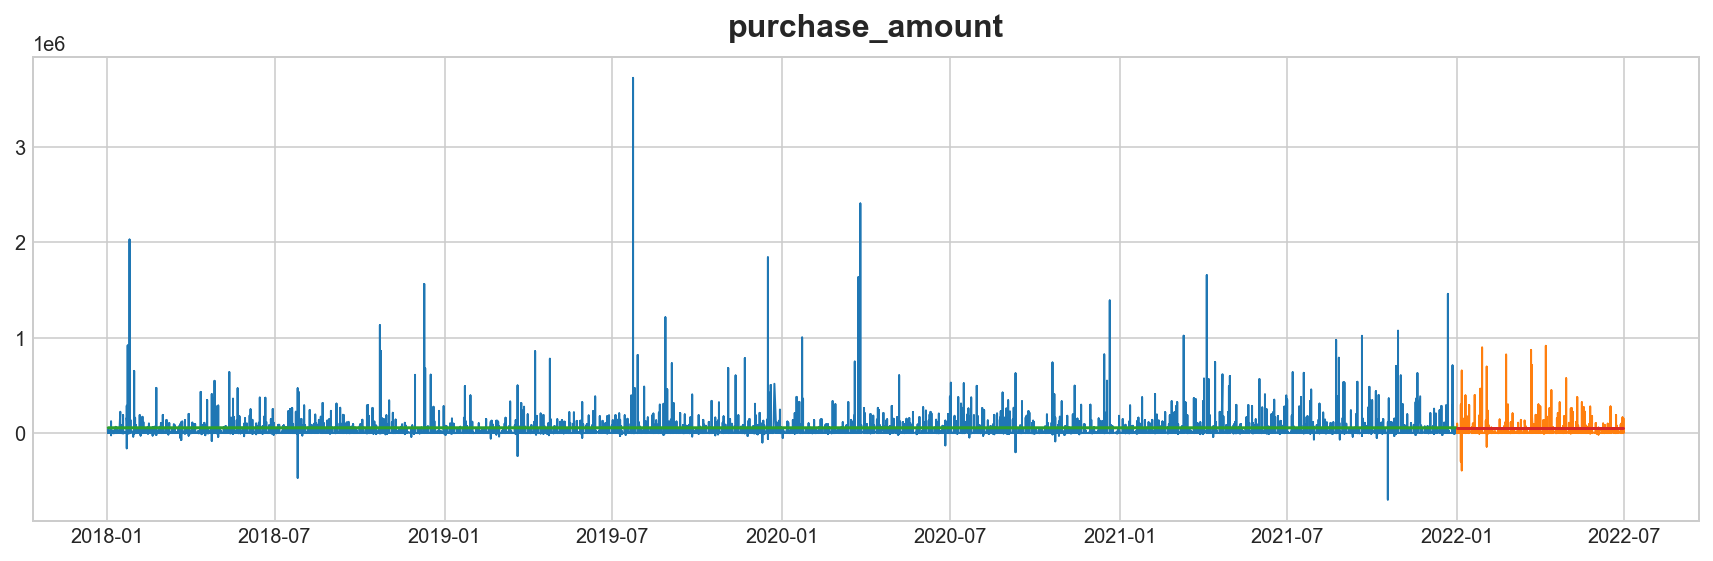

In [69]:
evaluate(target, ma3)

In [70]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232


7

In [71]:
period = 7
ma7 = 'moving_average7'
rolling_amount = round(X_train.purchase_amount.rolling(period).mean()[-1], 2)
predictions_train[ma7] = rolling_amount
predictions_validate[ma7] = rolling_amount

In [91]:
X_train.purchase_amount.rolling(period).mean()

order_date
2018-01-02          NaN
2018-01-03          NaN
2018-01-04          NaN
2018-01-05          NaN
2018-01-06          NaN
                ...    
2021-12-27   710,133.30
2021-12-28   696,842.13
2021-12-29   679,940.43
2021-12-30   664,530.52
2021-12-31   664,538.44
Freq: D, Name: purchase_amount, Length: 1460, dtype: float64

purchase_amount -- RMSE train: 937941
purchase_amount -- RMSE validate: 821292


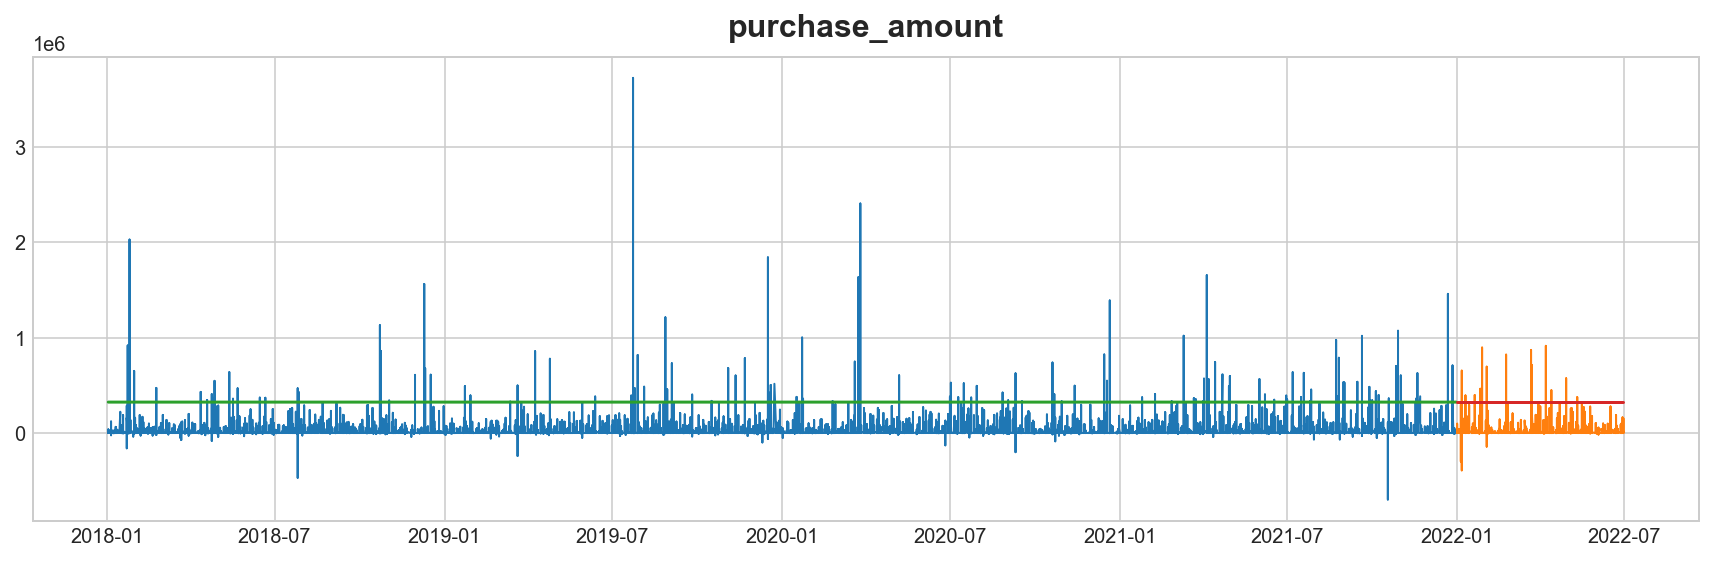

In [72]:
evaluate(target, ma7)

In [73]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292


In [74]:
period = 28
ma28 = 'moving_average28'
rolling_amount = round(X_train.purchase_amount.rolling(period).mean()[-1], 2)
predictions_train[ma28] = rolling_amount
predictions_validate[ma28] = rolling_amount

purchase_amount -- RMSE train: 895879
purchase_amount -- RMSE validate: 799475


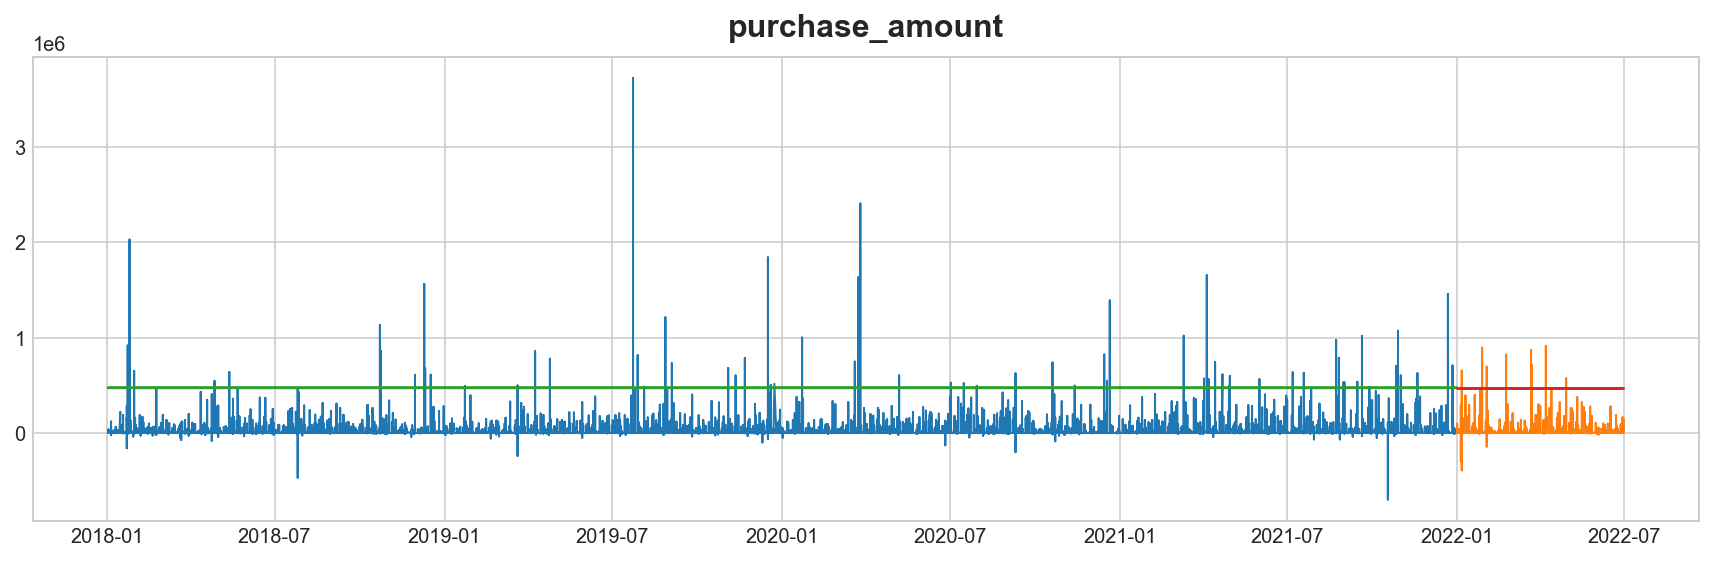

In [75]:
evaluate(target, ma28)

In [76]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average28,895879,799475


In [77]:
period = 52
ma52 = 'moving_average52'
rolling_amount = round(X_train.purchase_amount.rolling(period).mean()[-1], 2)
predictions_train[ma52] = rolling_amount
predictions_validate[ma52] = rolling_amount

purchase_amount -- RMSE train: 880974
purchase_amount -- RMSE validate: 800916


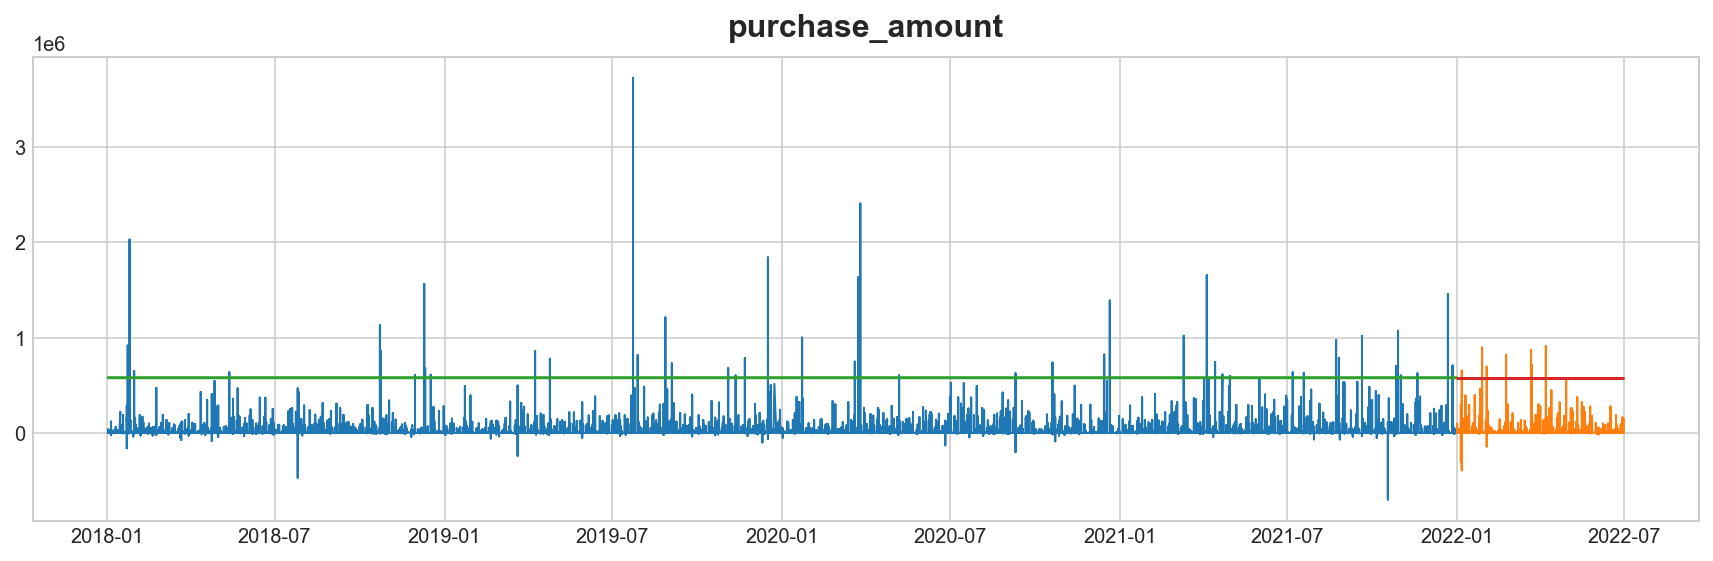

In [78]:
evaluate(target, ma52)

In [47]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average7,937941,821292
4,moving_average28,895879,799475
5,moving_average52,880974,800916


In [79]:
period = 90
ma90 = 'moving_average90'
rolling_amount = round(X_train.purchase_amount.rolling(period).mean()[-1], 2)
predictions_train[ma90] = rolling_amount
predictions_validate[ma90] = rolling_amount

purchase_amount -- RMSE train: 877849
purchase_amount -- RMSE validate: 811962


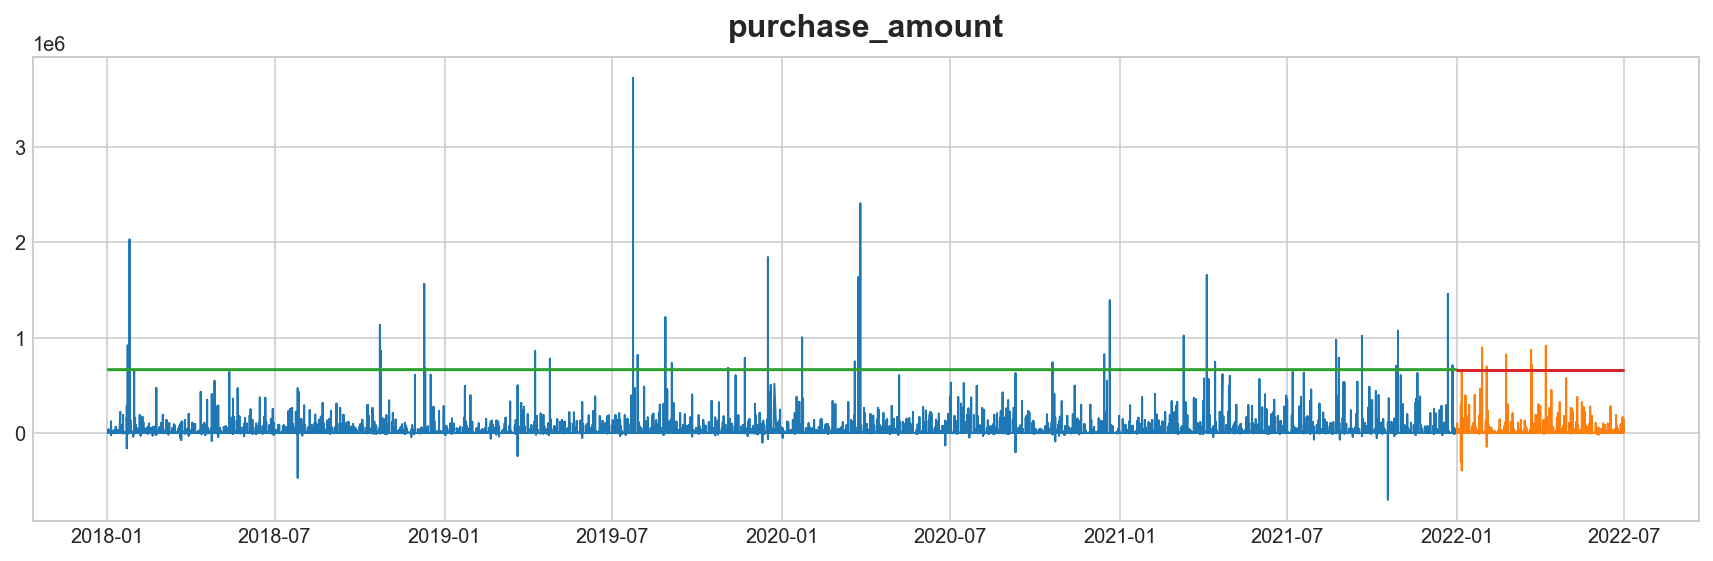

In [80]:
evaluate(target, ma90)

In [81]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average28,895879,799475
4,moving_average52,880974,800916
5,moving_average90,877849,811962


#### Exponential Moving average

An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average simple moving average (SMA), which applies an equal weight to all observations in the period.

purchase_amount -- RMSE train: 695497
purchase_amount -- RMSE validate: 633502


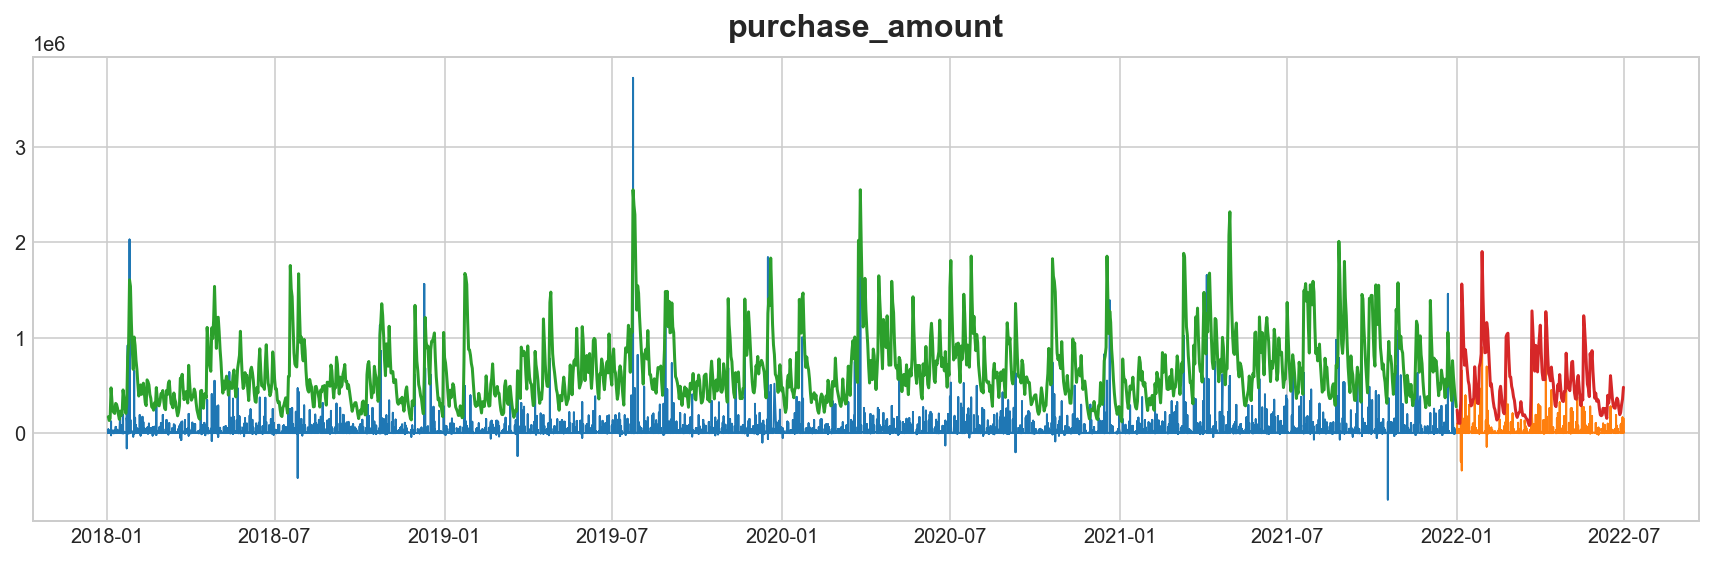

In [82]:
# compute moving average
ema7 = 'exponential moving average 7'
predictions_train[ema7] = X_train.ewm(span=7).mean()
predictions_validate[ema7] = X_validate.ewm(span=7).mean()
evaluate(target, ema7)

In [83]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average28,895879,799475
4,moving_average52,880974,800916
5,moving_average90,877849,811962
6,exponential moving average 7,695497,633502


purchase_amount -- RMSE train: 826159
purchase_amount -- RMSE validate: 748615


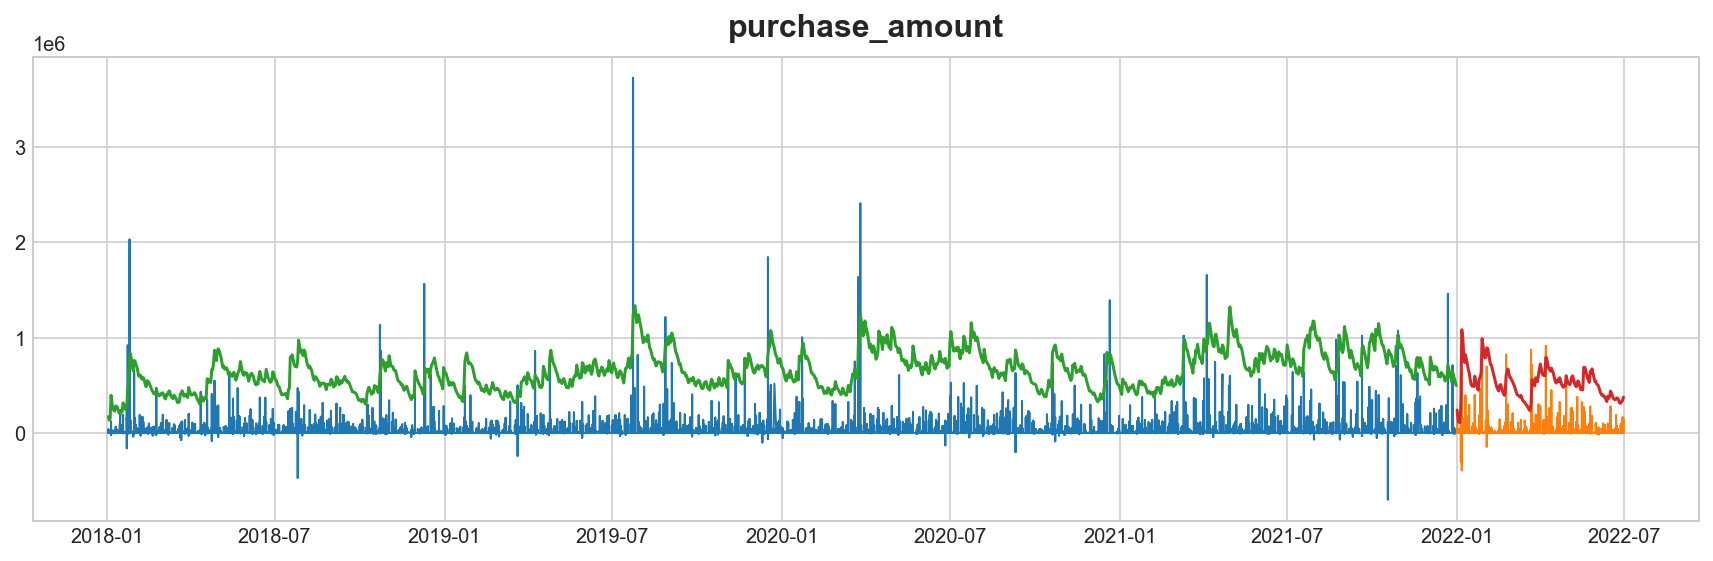

In [84]:
# compute moving average
ema28 = 'exponential moving average 28'
predictions_train[ema28] = X_train.ewm(span=28).mean()
predictions_validate[ema28] = X_validate.ewm(span=28).mean()
evaluate(target, ema28)

In [85]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average28,895879,799475
4,moving_average52,880974,800916
5,moving_average90,877849,811962
6,exponential moving average 7,695497,633502
7,exponential moving average 28,826159,748615


purchase_amount -- RMSE train: 495348
purchase_amount -- RMSE validate: 451023


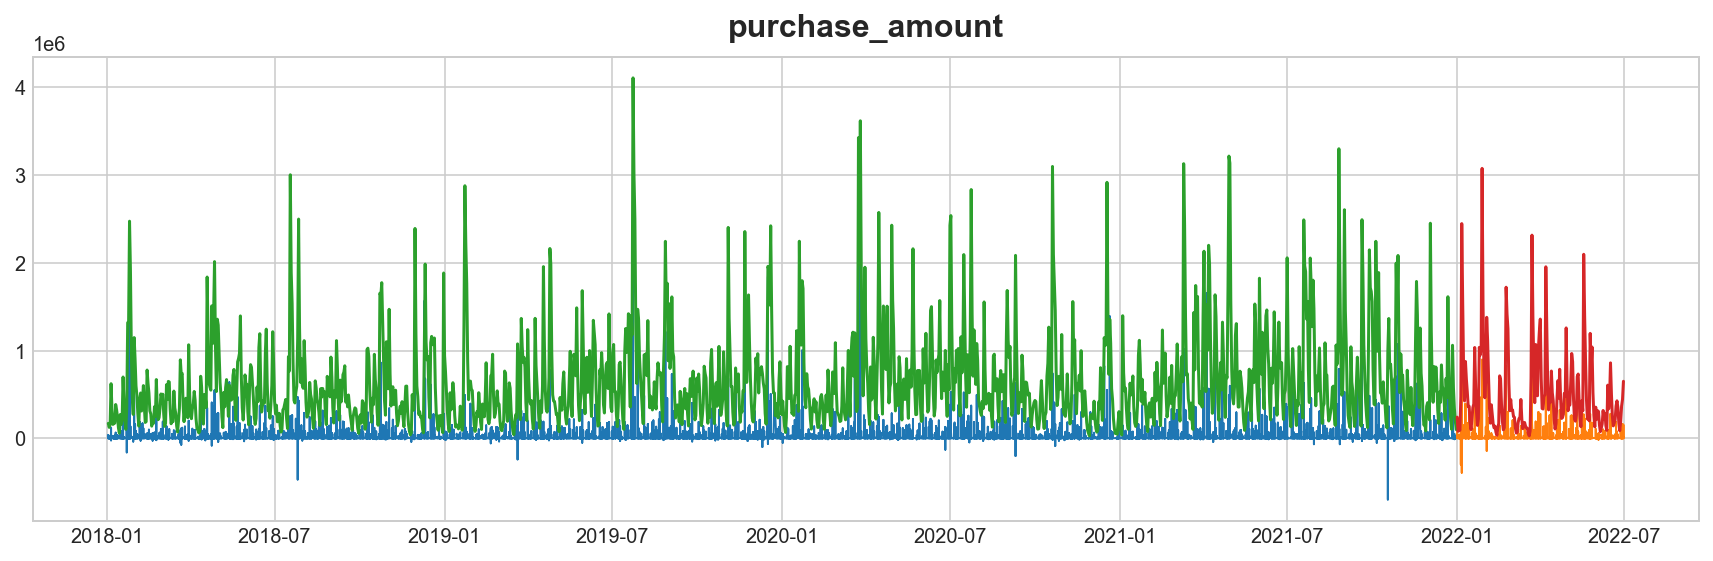

In [86]:
# compute moving average
ema3 = 'exponential moving average 3'
predictions_train[ema3] = X_train.ewm(span=3).mean()
predictions_validate[ema3] = X_validate.ewm(span=3).mean()
evaluate(target, ema3)

In [87]:
scores

,model_name,train_score,validate_score
0,baseline,877795,810253
1,moving_average3,1063006,922232
2,moving_average7,937941,821292
3,moving_average28,895879,799475
4,moving_average52,880974,800916
5,moving_average90,877849,811962
6,exponential moving average 7,695497,633502
7,exponential moving average 28,826159,748615
8,exponential moving average 3,495348,451023


### Holt's Linear Trend Model

In [90]:
holt_linear = 'holt_linear'

In [94]:
# create the Holt object 
holt = Holt(X_train[target], exponential=False, damped_trend=True)
# fit the model 
holt = holt.fit(optimized=True)
# make predictions for the train set
predictions_train[holt_linear] = round(holt.predict(start = X_train.index[0],
                                   end = X_train.index[-1]),2)
# make predictions for the validate set
predictions_validate[holt_linear] = round(holt.predict(start = X_validate.index[0],
                                   end = X_validate.index[-1]),2)

In [97]:
evaluate_rmse(target, holt_linear)

##### Holt Linear perdorms worse than a baseline. 
Because the data is now linear

In [101]:
scores[(scores.model_name == 'baseline')|(scores.model_name==holt_linear)]

,model_name,train_score,validate_score
0,baseline,877795,810253
61,holt_linear,898515,838245


### Exponential Smoothing

Doesn't work with negtive numbers and zeros in the data set

In [172]:
# Models for quantity
fit1 = ExponentialSmoothing(X_train[X_train.purchase_amount>0], seasonal_periods=365, trend='add', seasonal='add', use_boxcox=True)
fit1 = fit1.fit()

In [169]:
predictions_train['exp_smoothing']= fit1.forecast(X_train.shape[0]).tolist()
predictions_validate['exp_smoothing']=fit1.forecast(X_validate.shape[0]).tolist()

In [170]:
predictions_validate['exp_smoothing'].isnull().sum()

0

In [167]:
scores # better result when I add trend='add', but still awfull results

,model_name,train_score,validate_score
0,baseline,877795,810253
1,Moving Average 2,585705,523689
2,Moving Average 3,707206,646148
3,Moving Average 4,761101,712618
4,Moving Average 5,795766,740410
...,...,...,...
59,Exp Moving Average 30,829234,751140
60,Exp Moving Average 31,830626,752275
61,holt_linear,898515,838245
62,exp_smoothing,979626,876340


### Naive predictions
just copypaste the values from year ago

In [10]:
(X_train.index + pd.Timedelta('1 Y') ).normalize()

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='order_date', length=1460, freq='D')

In [185]:
X_train.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-11',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='order_date', length=1460, freq='D')

In [28]:
result_index = (X_validate.index - pd.Timedelta('1 Y') + pd.Timedelta('1 D')).normalize()

In [33]:
predictions_validate['naive'] = X_train.loc[result_index].purchase_amount.to_list()

In [35]:
np.sqrt(mean_squared_error(X_validate[target], predictions_validate.naive))

1148417.8075708207

Way too high RMSE. It doesn't work for this data set.